# Batch Image analysis pipeline: assess nuclear signal intensity (HCR, PLA)

Written by JA Zagalak (julian.zagalak@kcl.ac.uk):
---
*adapted from: Introduction to Image Analysis Workshop*
*by Stefania Marcotti, KCL*


*CC-BY-SA-4.0 license: creativecommons.org/licenses/by-sa/4.0/*

---

We run the pipeline on a directory inside the data folder, which then processes all images in treatment specific subfolders (e.g. Well1, Well2). Pipeline requires a minimum of 2 treatment groups with each 2 images. If single images are to be analysed condider duplicating all iamges before running the pipeline.

### Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from os import walk

import skimage as ski
from skimage import io
from skimage import filters, measure, morphology, segmentation
from skimage.io import imread, imshow

from skimage.morphology import erosion, dilation
from scipy import ndimage as ndi

from matplotlib import colormaps

### Import data
Here we define the top-level folder that contains all experimental data and automatically detect all subfolders and assign them as treatment groups - note the use of the wildcard `*`!

In [2]:
# read all .tif files in folder
#Use strucutre with experiment directory with each treatment having a subfolder

mypath = '../../Data/HCR1/'

f = []
for (dirpath, dirnames, filenames) in walk(mypath):
    f.extend(sorted(dirnames))
    break

files = []
info = []
im_all = list()

c = 0
for c in range(len(f)):
    treat = f[c]
    t = mypath + treat + "/*.tif"
    files = np.append(files, t)

#Automatic Treatment/sample description
info = f
#Manual Treatment/sample description
#info = ['NC ms','NC rb','0.2 mg/l','0.5 mg/l','1 mg/l','2 mg/l']
print(f)
n=0

for n in range(len(files)):
    bubu = files[n]
    dudu = io.imread(bubu)
    im_all = im_all + [dudu]    
print('Using',len(im_all),'Treatment groups')

['Well1', 'Well2', 'Well3', 'Well4', 'Well5', 'Well6', 'Well7', 'Well8']
Using 8 Treatment groups


In [7]:
# check the dimensions of the object
c_img = 0
for ccou in range(len(im_all)):
    if len(im_all[ccou].shape) <4:
        print('! Image set', ccou+1, 'has wrong dimensions:', im_all[ccou].shape)
        continue
        #np.insert(im_all[ccou],0,1)
    print('Image set', ccou+1, 'dimensions:', im_all[ccou].shape)
    c_img = c_img + im_all[ccou].shape[0]
print('Input:', c_img,'images in',len(im_all), 'treatment groups (factor)')

Image set 1 dimensions: (6, 2, 1200, 1920)
Image set 2 dimensions: (5, 2, 1200, 1920)
Image set 3 dimensions: (6, 2, 1200, 1920)
Image set 4 dimensions: (5, 2, 1200, 1920)
Image set 5 dimensions: (5, 2, 1200, 1920)
Image set 6 dimensions: (6, 2, 1200, 1920)
Image set 7 dimensions: (5, 2, 1200, 1920)
Image set 8 dimensions: (5, 2, 1200, 1920)
Input: 43 images in 8 treatment groups (factor)


In [4]:
#Optional:
#Transpose to standard format (n,c,x,y) if elements in different order
for cou in range(len(im_all)):
    im_all[cou] = np.transpose(im_all[cou], (0, 3, 1, 2))
    print('New set', cou+1, 'dimensions:', im_all[cou].shape)

New set 1 dimensions: (6, 3, 1200, 1920)
New set 2 dimensions: (5, 3, 1200, 1920)
New set 3 dimensions: (5, 3, 1200, 1920)
New set 4 dimensions: (5, 3, 1200, 1920)
New set 5 dimensions: (5, 3, 1200, 1920)
New set 6 dimensions: (4, 3, 1200, 1920)
New set 7 dimensions: (4, 3, 1200, 1920)
New set 8 dimensions: (4, 3, 1200, 1920)


We can visualise some example nuclear images by running the cell below. The variable `n` lets us select the treatment group, `im_idx` indicates which image we want to open whereas `ch_dapi` (usually ch0) let's us select the DAPI channel.

Well1 image number 1


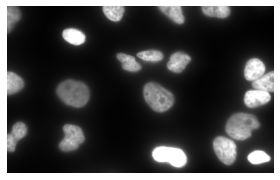

In [6]:
# select image for threshold and filter testing 
#Select treatment group
n = 0
#Select image number and DAPI channel (ch0 ususally)
im_idx = 0
ch_dapi = 0
im = im_all[n][im_idx,ch_dapi,]
print(info[n], 'image number', im_idx+1 )

# display the chosen image
fig, ax = plt.subplots(figsize=(4,3))
ax.imshow(im, cmap='gray')
ax.axis('off')
plt.tight_layout()

### Construct a kernel for morphology erosion and test different settings
Testing erosion settings

In [8]:
#build kernel for morphology erosion
cross = np.array([[0,1,0],
                  [1,1,1],
                  [0,1,0]])
h_line = np.array([[0,0,0],
                  [1,1,1],
                  [0,0,0]])
v_line = np.array([[0,1,0],
                  [0,1,0],
                  [0,1,0]])

def multi_erosion(image, kernel, iterations):
    for i in range(iterations):
        image = erosion(image, kernel)
    return image


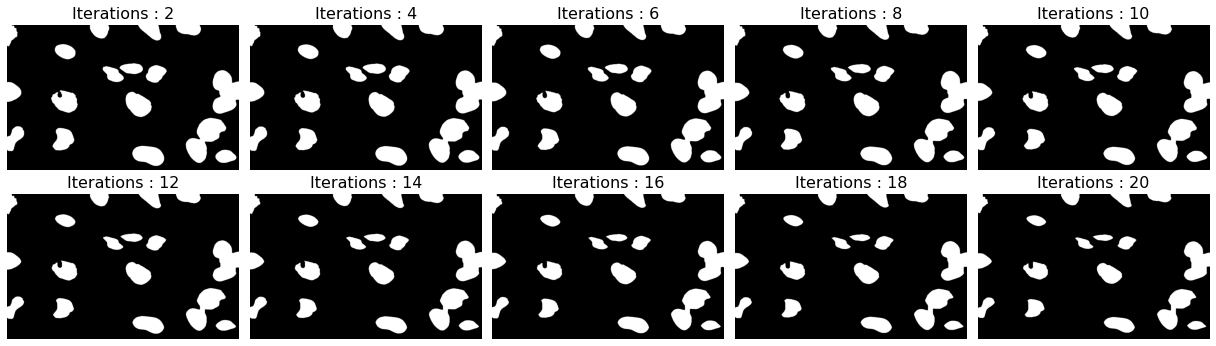

In [9]:
#Test optimal number of erosion iterations here
im_gauss = filters.gaussian(im, sigma=2)
# threshold with Otsu
thresh = filters.threshold_otsu(im_gauss)
im_thresh = im_gauss > thresh
im_thresh = ndi.binary_fill_holes(im_thresh)
ites = [2,4,6,8,10,12,14,16,18,20]
fig, ax = plt.subplots(2, 5, figsize=(17, 5))
for n, ax in enumerate(ax.flatten()):
    ax.set_title(f'Iterations : {ites[n]}', fontsize = 16)
    new_circle = multi_erosion(im_thresh, v_line, ites[n])
    ax.imshow(new_circle, cmap = 'gray');
    ax.axis('off')
fig.tight_layout()

### Set Thresholding and Filtering
Using Gaussian thresholding (change variable `sig`) and otsu thresholding. Minimal distance to define objects can be set with variable `min_dis`. If erosion is not desired then set `n_erosion` = 0. Select the channel to be used for measurments using `ch_red` (usually ch2 for red)  

processing set: Well1
image: 1
image: 2
image: 3
image: 4
image: 5
image: 6
processing set: Well2
image: 1
image: 2
image: 3
image: 4
image: 5
processing set: Well3
image: 1
image: 2
image: 3
image: 4
image: 5
image: 6
processing set: Well4
image: 1
image: 2
image: 3
image: 4
image: 5
processing set: Well5
image: 1
image: 2
image: 3
image: 4
image: 5
processing set: Well6
image: 1
image: 2
image: 3
image: 4
image: 5
image: 6
processing set: Well7
image: 1
image: 2
image: 3
image: 4
image: 5
processing set: Well8
image: 1
image: 2
image: 3
image: 4
image: 5


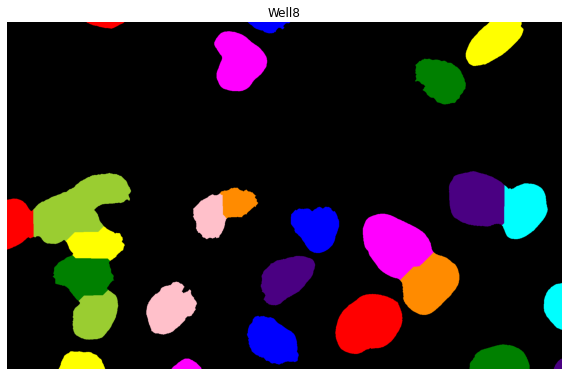

In [11]:
#Set thresholding and filtering parameters
sig = 1.5
n_erosion = 5
min_dis = 60

#Choose the channel in which to measure HCR signal (usually ch1 or ch2)
ch_red = 1

# initialise output
mega_props = pd.DataFrame()
mega_obj = []

# set up for loop for all the images available in the folder
t = 0

for count in im_all:
    nset = count.shape[0]
    obj_count = []
    props_df = pd.DataFrame()
    im_idx = 0
    print('processing set:', info[t])
    for im_idx in range(nset):
        print('image:', im_idx+1)
        # open image (only ch0)
        im = count[im_idx,ch_dapi,]
        im_2 = count[im_idx,ch_red,]
        # filter with Gaussian
        im_gauss = filters.gaussian(im, sigma=sig)
        # threshold with Otsu
        thresh = filters.threshold_otsu(im_gauss)
        im_thresh = im_gauss > thresh
        im_thresh = ndi.binary_fill_holes(im_thresh)
        im_thresh = multi_erosion(im_thresh, cross, n_erosion)
        #Watershed for segmentation
        distance = ndi.distance_transform_edt(im_thresh)
        local_max_coords = ski.feature.peak_local_max(
        distance, min_distance= min_dis, exclude_border=False)
        local_max_mask = np.zeros(distance.shape, dtype=bool)
        local_max_mask[tuple(local_max_coords.T)] = True
        markers = ski.measure.label(local_max_mask)
        segmented_cells = ski.segmentation.watershed(-distance, markers, mask=im_thresh)
        # label mask
        labels = measure.label(segmented_cells)
        # count objects
        obj_count = np.append(obj_count,labels.max())
        # measure properties
        props = measure.regionprops_table(labels, im_2, properties=['area', 'solidity', 'eccentricity','extent','intensity_mean','label'])
        props['Factor'] = info[t]
        props_df = pd.concat([props_df, pd.DataFrame(props)], ignore_index=True)
        
    mega_props = pd.concat([mega_props, props_df], ignore_index=True)
    mega_obj = np.append(mega_obj, obj_count)
    t = t+1
    

fig, axs = plt.subplots(figsize=(8,6))
axs.imshow(ski.color.label2rgb(segmented_cells, bg_label=0))
axs.set_title(info[t-1])
axs.set_axis_off()

plt.tight_layout()


In [12]:
# how many nuclei did we analyse?
print('We analysed', mega_obj.sum(), 'segmented nuclei in', c_img, 'images')

We analysed 869.0 segmented nuclei in 43 images


In [13]:
#check measured properties
print('Mean of nuclear measurments per treatment group (Factor)')
print(mega_props.groupby(['Factor']).mean())

#Use groupby and get_group to make individual dataframes for each treatment group
#then add each factor dataframe as element to a dictionary
grouped_props = mega_props.groupby(['Factor'])

props_dict = {}

for c in range(len(info)):
    z = info[c]
    df1 = grouped_props.get_group(z)
    props_dict[z] = df1
    
print(props_dict[info[0]].head())


Mean of nuclear measurments per treatment group (Factor)
                area  solidity  eccentricity    extent  intensity_mean  \
Factor                                                                   
Well1   17338.465649  0.953785      0.721562  0.716286     2551.378198   
Well2   20652.703297  0.947288      0.732949  0.717076       87.076386   
Well3   22733.021739  0.965747      0.709981  0.738950      355.021832   
Well4   21783.800000  0.957478      0.725709  0.731476      130.002810   
Well5   16637.372549  0.957036      0.731568  0.719231     3506.432774   
Well6   18840.700855  0.951169      0.725427  0.714120      115.161540   
Well7   18907.239669  0.950675      0.678425  0.726427      848.644055   
Well8   19952.928000  0.940813      0.718645  0.711389      155.038316   

            label  
Factor             
Well1   11.977099  
Well2   10.010989  
Well3    8.489130  
Well4    9.666667  
Well5   11.009804  
Well6   10.478632  
Well7   12.710744  
Well8   13.080000  
  

### Plot results

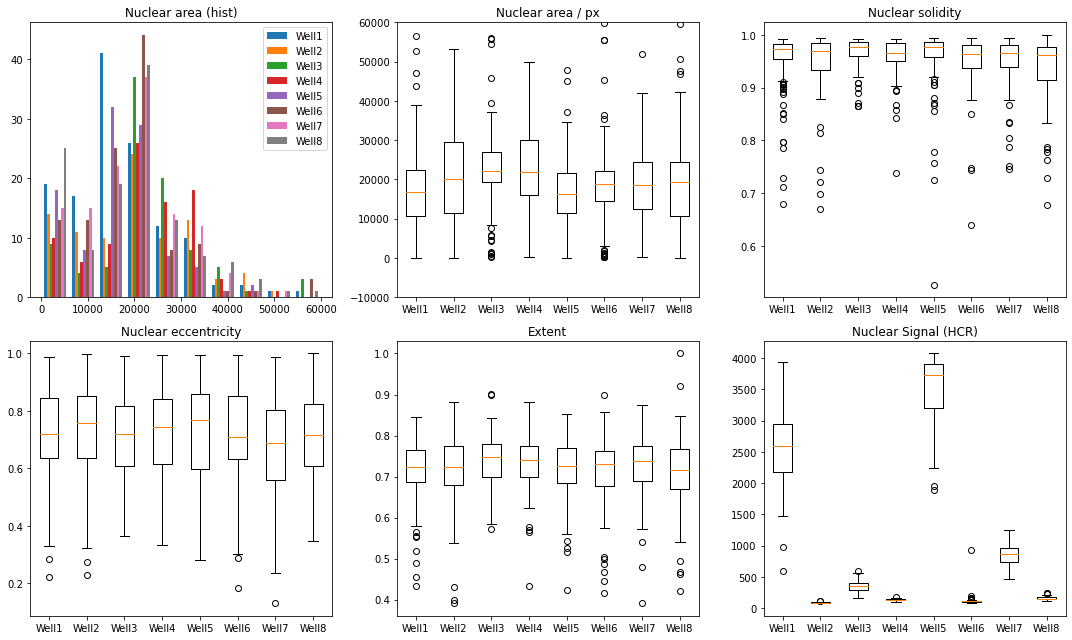

In [15]:
#Select ymax as a cutoff for cell size in pixel
ymax = 60000


#Depending on the number of treatment groups (2-8) we will store the array to be plotted in a string variable stringting
if len(info) > 8 or len(info) < 2:
    print('Too many/Too few treatment groups, range is 2-8')
elif len(info) == 2:
    stringting = "[props_dict[info[0]]['area'],props_dict[info[1]]['area']]"
elif len(info) == 3:
    stringting = "[props_dict[info[0]]['area'],props_dict[info[1]]['area'],props_dict[info[2]]['area']]"
elif len(info) == 4:
    stringting = "[props_dict[info[0]]['area'],props_dict[info[1]]['area'],props_dict[info[2]]['area'],props_dict[info[3]]['area']]"
elif len(info) == 5:
    stringting = "[props_dict[info[0]]['area'],props_dict[info[1]]['area'],props_dict[info[2]]['area'],props_dict[info[3]]['area'],props_dict[info[4]]['area']]"
elif len(info) == 6:
    stringting = "[props_dict[info[0]]['area'],props_dict[info[1]]['area'],props_dict[info[2]]['area'],props_dict[info[3]]['area'],props_dict[info[4]]['area'],props_dict[info[5]]['area']]"
elif len(info) == 7:
    stringting = "[props_dict[info[0]]['area'],props_dict[info[1]]['area'],props_dict[info[2]]['area'],props_dict[info[3]]['area'],props_dict[info[4]]['area'],props_dict[info[5]]['area'],props_dict[info[6]]['area']]"
elif len(info) == 8:
    stringting = "[props_dict[info[0]]['area'],props_dict[info[1]]['area'],props_dict[info[2]]['area'],props_dict[info[3]]['area'],props_dict[info[4]]['area'],props_dict[info[5]]['area'],props_dict[info[6]]['area'],props_dict[info[7]]['area']]"

                   
# display some results
fig, axs = plt.subplots(2, 3, figsize=(15,9))

axs[0,0].hist(eval(stringting), bins = 10, label=info, range=[0,ymax])
axs[0,0].set_title('Nuclear area (hist)')
axs[0,0].legend(prop={'size':10})

axs[0,1].boxplot(eval(stringting),labels=info)
axs[0,1].set_title('Nuclear area / px')
axs[0,1].set_ylim([-10000, ymax])
stringting = stringting.replace('area','solidity')
                   
axs[0,2].boxplot(eval(stringting),labels=info)
axs[0,2].set_title('Nuclear solidity')
stringting = stringting.replace('solidity','eccentricity')
                   
axs[1,0].boxplot(eval(stringting),labels=info)
axs[1,0].set_title('Nuclear eccentricity')
stringting = stringting.replace('eccentricity','extent')

axs[1,1].boxplot(eval(stringting),labels=info)
axs[1,1].set_title('Extent')
stringting = stringting.replace('extent','intensity_mean')
                   
axs[1,2].boxplot(eval(stringting),labels=info)
axs[1,2].set_title('Nuclear Signal (HCR)')

plt.tight_layout()


### All done
